# AxoID with Optic Flow Warping
Notebook used to test detection and tracking together to start the work for AxoID.  
This is the second iteration with use of Optic Flow Warping to get automatically good annotations.
Workflow:
   1. Detection:
      1. Make a binary segmentation out of the temporal projection of the warped stack
      2. Automatically find frames where the warping is nice
      3. Use these frames with the projection's segmentation as annotated frames to fine tune network with them
      4. Predict the whole experiment
   2. Tracking:
      1. Select an initialization frame automatically, or use projection's segmentation
      2. Track axons:
         * Train model
         * Generate final identities
   3. User correction/others ?

In [2]:
%matplotlib inline

import os, sys, time, shutil, copy, time
import re
import warnings
import random
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, external, measure, morphology, filters, feature, color, segmentation
from sklearn import cluster
from scipy import ndimage as ndi
from scipy import stats
import cv2
import imgaug.augmenters as iaa

import torch

# Add parent folder to path in order to access `axoid`
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from axoid.utils.image import imread_to_float, to_npint, overlay_preds_targets, overlay_mask, \
                              overlay_mask_stack, overlay_contours, rg2gray
from axoid.utils.metrics import dice_coef, gradient_norm
from axoid.utils.ccreg import register_stack, shift_image
from axoid.utils.processing import nlm_denoising, fuse_small_objects, flood_fill
# Following are copy-pasted from other folders. Check that they are up-to-date
from axoid.detection.deeplearning.data import normalize_range, get_all_dataloaders, pad_transform, pad_transform_stack, compute_weights
from axoid.detection.deeplearning.finetuning import fine_tune, ROIAnnotator_mpl
from axoid.detection.deeplearning.loss import get_BCEWithLogits_loss
from axoid.detection.deeplearning.metric import get_dice_metric
from axoid.detection.deeplearning.model import CustomUNet, load_model
from axoid.detection.deeplearning.test import predict, predict_stack, evaluate, evaluate_stack
from axoid.tracking.model import InternalModel
from axoid.tracking.utils import get_rules, rules_violated

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


In [3]:
# Load experiment
# experiment = "/data/talabot/experiments/to_annotate/SS29893_20190328_tdTomGC6fopt-fly3/SS29893_20190328_tdTomGC6fopt-fly3_001/"
experiment = "/mnt/NAS/CLC/Ascending_Project/SS29893/2P/20190328/SS29893-tdTomGC6fopt-fly3/SS29893-tdTomGC6fopt-fly3-001/2Pimg/"
ref_num = 1

rgb_stack = imread_to_float(os.path.join(experiment, "RGB.tif"))
if os.path.isfile(os.path.join(experiment, "seg_ROI.tif")):
    seg_stack = imread_to_float(os.path.join(experiment, "seg_ROI.tif"))
else:
    seg_stack = None
if os.path.isfile(os.path.join(experiment, "weights.tif")):
    weights_stack = imread_to_float(os.path.join(experiment, "weights.tif"))
else:
    weights_stack = None

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 4))
    plt.suptitle(experiment)
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:
        plt.subplot(132)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    if weights_stack is not None:
        plt.subplot(133)
        plt.title("Pixel weighting")
        plt.imshow(weights_stack[image], cmap="gray")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# # Compute registration through cross-correlation
# reg_rgb, reg_rows, reg_cols = register_stack(rgb_stack, ref_num=ref_num, return_shifts=True)
# reg_rgb = reg_rgb.clip(0, 1)
# if seg_stack is not None:
#     reg_seg = np.zeros_like(seg_stack)
#     for i in range(len(reg_seg)):
#         reg_seg[i] = shift_image(seg_stack[i], reg_rows[i], reg_cols[i])
#     reg_seg = reg_seg.clip(0, 1)
# else:
#     reg_seg = None

# plt.figure(figsize=(12, 4))
# plt.subplot(131)
# plt.title("Raw time projection")
# plt.imshow(rgb_stack.mean(0) / rgb_stack.mean(0).max())
# plt.subplot(132)
# plt.title("Registered time projection")
# plt.imshow(reg_rgb.mean(0) / reg_rgb.mean(0).max())
# plt.subplot(133)
# plt.title("Registered time projection (median)")
# plt.imshow(np.median(reg_rgb, 0) / np.median(reg_rgb, 0).max())
# plt.tight_layout()
# plt.show()

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

# 1. Detection
Detect ROIs on the frames as a binary segmentation by using the warped experiment.

In [4]:
# Test warping (not done here)
if os.path.isfile(os.path.join(experiment, "warped_RGB.tif")):
    wrp_stack = imread_to_float(os.path.join(experiment, "warped_RGB.tif"))
    
    @interact(image=(0, len(rgb_stack) - 1))
    def plot_experiment(image=0):
        plt.figure(figsize=(10, 10))
        plt.subplot(221)
        plt.title("Raw input")
        plt.imshow(rgb_stack[image])
        plt.subplot(222)
        plt.title("Warped input")
        plt.imshow(wrp_stack[image])
#         plt.subplot(223)
#         plt.title("CC-registered time projection")
#         plt.imshow(reg_rgb.mean(0) / reg_rgb.mean(0).max())
        plt.subplot(224)
        plt.title("Warped time projection")
        plt.imshow(wrp_stack.mean(0) / wrp_stack.mean(0).max())
        plt.show()
    
else:
    wrp_stack = None
    print("No available warping")

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

In [4]:
# Remove first frame from stacks (useful to avoid weird artifacts)
rgb_stack = rgb_stack[1:]
wrp_stack = wrp_stack[1:]

## A. Temporal projection's segmentation
Make a binary segmentation of the temporal projection.

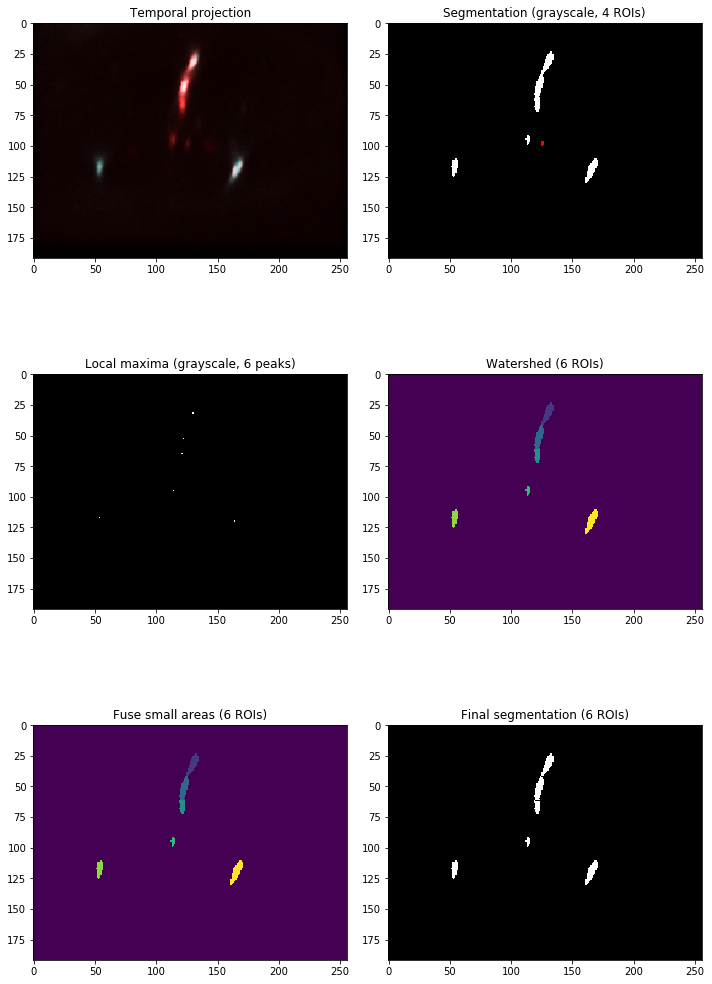

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

In [5]:
# Test ROI detection on warped temporal projection
min_area = 11

def segment_projection(projection, min_area, plot_steps=False, separation_border=True):
    # Binary segmentation
    bin_projection = rg2gray(projection)
    bin_projection = bin_projection > filters.threshold_local(bin_projection, 25, offset=-0.05)
    # Delete small ROIs
    small_rois = np.logical_xor(bin_projection, morphology.remove_small_objects(bin_projection, min_area))
    bin_projection = np.logical_xor(bin_projection, small_rois)

    if separation_border:    
        # Peaks detection
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            peaks = morphology.h_maxima(rg2gray(projection), 0.05)
            peaks = segmentation.clear_border(peaks)
            peaks *= bin_projection # remove peaks outside of segmentation

        # Watershed to separate touching axons
        markers = measure.label(peaks, connectivity=1)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            watershed = morphology.watershed(-rg2gray(projection), markers, mask=bin_projection)

        # Fuse touching small areas
        post_fusion = fuse_small_objects(watershed, min_area)

        # Add border between touching labels
        sep_labels = post_fusion.copy()
        for i in np.unique(post_fusion):
            if i == 0:
                continue
            # use post_fusion for a 2 pixel-wide separation, or sep_labels for a 1 pixel wide one
            sep_labels[np.logical_and(morphology.dilation(sep_labels == i), sep_labels != i)] = 0

        # Convert to boolean
        seg_projection = sep_labels.astype(np.bool)
    else:
        seg_projection = bin_projection

    if plot_steps:
        plt.figure(figsize=(10, 15))
        plt.subplot(321)
        plt.title("Temporal projection")
        plt.imshow(projection)
        plt.subplot(322)
        plt.title("Segmentation (grayscale, %d ROIs)" % measure.label(bin_projection, connectivity=1, return_num=True)[1])
        plt.imshow(overlay_mask(bin_projection.astype(np.float32), small_rois, 1, [1,0,0]))
        if separation_border:
            plt.subplot(323)
            plt.title("Local maxima (grayscale, %d peaks)" % measure.label(peaks, connectivity=1, return_num=True)[1])
            plt.imshow(peaks, cmap="gray")
            plt.subplot(324)
            plt.title("Watershed (%d ROIs)" % measure.label(watershed, connectivity=1, return_num=True)[1])
            plt.imshow(watershed)
            plt.subplot(325)
            plt.title("Fuse small areas (%d ROIs)" % measure.label(watershed, connectivity=1, return_num=True)[1])
            plt.imshow(post_fusion)
            plt.subplot(326)
            plt.title("Final segmentation (%d ROIs)" % measure.label(seg_projection, connectivity=1, return_num=True)[1])
            plt.imshow(seg_projection, cmap="gray")
        plt.tight_layout()
        plt.show()
    
    return seg_projection


projection = wrp_stack.mean(0)
# projection /= projection.max() # optional rescaling
seg_projection = segment_projection(projection, min_area, True, True)
                                    
@interact(image=(0, len(wrp_stack) - 1))
def plot(image=0):
    plt.figure(figsize=(8,8))
    plt.title("Input with contour of projection's segmentation")
    plt.imshow(overlay_contours(wrp_stack[image], seg_projection))
    plt.show()

## B. Find good warped frames
Find metrics to automatically detect correctly warped frames to use for the fine tuning.

Create "metrics" of registration (as cross-correlation to temporal projection), and take argmax frames.

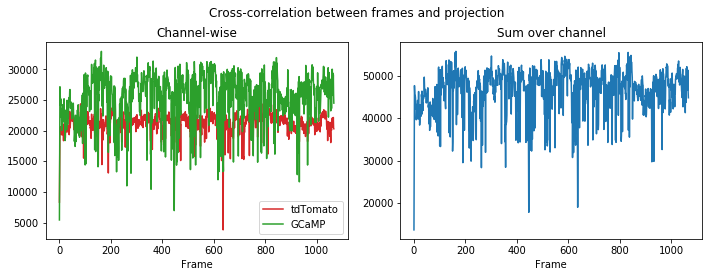

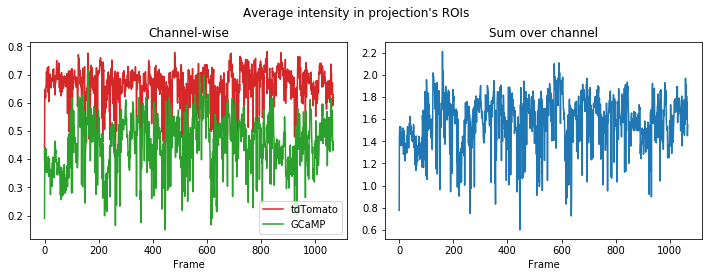

Index of best frames: [796, 792, 82, 743, 832, 775, 798, 799, 204, 384]


interactive(children=(IntSlider(value=0, description='image', max=9), Output()), _dom_classes=('widget-interac…

In [6]:
n_annot_idx = 10
norm_wrp_stack = (wrp_stack - wrp_stack.mean((1,2), keepdims=True)) / wrp_stack.std((1,2), keepdims=True)
norm_projection = (projection - projection.mean((0,1), keepdims=True)) / projection.std((0,1), keepdims=True)

# Cross-correlation between frames and temporal projection
cc = np.sum(norm_wrp_stack * norm_projection, axis=(1,2))[..., :2]

plt.figure(figsize=(10,4))
plt.suptitle("Cross-correlation between frames and projection")
plt.subplot(121)
plt.title("Channel-wise")
plt.plot(cc[:, 0], "C3")
plt.plot(cc[:, 1], "C2")
plt.legend(["tdTomato", "GCaMP"])
plt.xlabel("Frame")
plt.subplot(122)
plt.title("Sum over channel")
plt.plot(cc.sum(1))
plt.xlabel("Frame")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Brightness in seg_proj ROIs
brightness = wrp_stack[:, seg_projection].mean(1)

plt.figure(figsize=(10,4))
plt.suptitle("Average intensity in projection's ROIs")
plt.subplot(121)
plt.title("Channel-wise")
plt.plot(brightness[:, 0], "C3")
plt.plot(brightness[:, 1], "C2")
plt.legend(["tdTomato", "GCaMP"])
plt.xlabel("Frame")
plt.subplot(122)
plt.title("Sum over channel")
plt.plot(brightness.sum(1))
plt.xlabel("Frame")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Choose best frames and display them
metric = cc[:, 0]
annot_idx = [metric.argmax()]
for i in range(1, n_annot_idx):
    tmp_metric = metric.copy()
    tmp_metric[annot_idx] = - np.inf
    annot_idx.append(tmp_metric.argmax())

print("Index of best frames:", annot_idx)
@interact(image=(0, n_annot_idx - 1))
def plot(image=0):
    plt.figure(figsize=(10,10))
    plt.suptitle("Frame %d" % annot_idx[image])
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(wrp_stack[annot_idx[image]])
    plt.subplot(222)
    plt.title("Projection")
    plt.imshow(projection)
    plt.subplot(223)
    plt.title("Overlay with projection's segmentation")
    plt.imshow(overlay_mask(wrp_stack[annot_idx[image]], seg_projection, 0.5, [1,1,1]))
    plt.subplot(224)
    plt.title("Projection of selected frames")
    plt.imshow(wrp_stack[annot_idx].mean(0))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

del cc, brightness, tmp_metric

Use some distance between frames (as cross-correlation), and cluster them according to this.

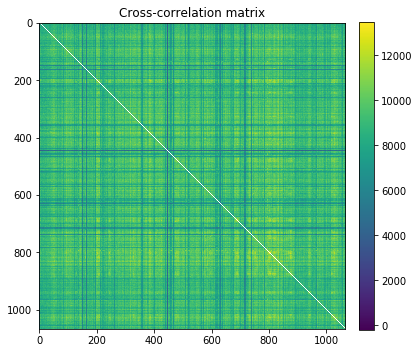

2 clusters found:
   0 with 296 frames - average cc = 10380
  -1 with 771 frames - average cc = 8528
Selected cluster: 0 with 296 frames


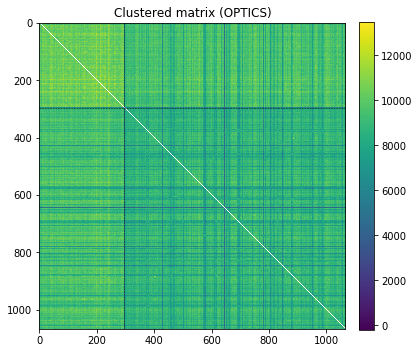

interactive(children=(Dropdown(description='Cluster n°', options=(-1, 0), value=-1), Checkbox(value=False, des…

In [8]:
# Cross-correlated frames to each other, and cluster results
stack = norm_wrp_stack[..., :2]
stack[..., 1] *= 0 # set G channel to 0 (faster than extracting only R, no idea why)

flat_frames = stack.reshape((len(stack), -1))
cc_matrix = flat_frames @ flat_frames.transpose()
# Set diagonal to nan
cc_matrix[np.eye(len(stack), dtype=np.bool)] = np.nan

# Display cross-correlation matrix
plt.figure(figsize=(6,6))
plt.title("Cross-correlation matrix")
plt.imshow(cc_matrix)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


### Cluster images based on distance/similarity matrix
matrix = cc_matrix
dist = np.nan_to_num(matrix)
dist = dist.max() - dist

# labels = cluster.DBSCAN(eps=20000, min_samples=10, metric="precomputed").fit_predict(dist)
labels = cluster.OPTICS(min_samples=20, max_eps=np.median(dist)/2, metric="precomputed").fit_predict(dist)
# labels = cluster.AgglomerativeClustering(n_clusters=None, affinity="precomputed", linkage="single", 
#                                          distance_threshold=np.median(dist)/2).fit_predict(dist)

average_cc = lambda l: np.nanmean(matrix[np.where(labels == l)[0]][:,np.where(labels == l)[0]])

# Compute and display cluster matrix
print("%d clusters found:" % len(np.unique(labels)))
max_cluster = np.nan
new_order = np.array([], dtype=np.uint16)
for l in np.unique(labels):
    if l != -1:
        if np.isnan(max_cluster) or average_cc(l) > average_cc(max_cluster):
            max_cluster = l
        new_order = np.append(new_order, np.where(labels == l)[0])
        if len(np.unique(labels)) < 10:
            print("  % 2d with %d frames - average cc = %d" % (l, np.sum(labels == l), average_cc(l)))
if -1 in labels:
    new_order = np.append(new_order, np.where(labels == -1)[0])
    if len(np.unique(labels)) < 10:
        print("  -1 with %d frames - average cc = %d" % (np.sum(labels == -1), average_cc(-1)))
if not np.isnan(max_cluster).all():
    print("Selected cluster: %d with %d frames" % (max_cluster, np.sum(labels == max_cluster)))
        
cluster_matrix = matrix[new_order][:, new_order]

plt.figure(figsize=(6,6))
plt.title("Clustered matrix (OPTICS)")
# Divider between clusters
cnt = 0
for l in np.unique(labels):
    if l != -1:
        cnt += np.sum(labels == l)
        plt.plot([0, len(stack)-1], [cnt, cnt], '--k', linewidth=0.5)
        plt.plot([cnt, cnt], [0, len(stack)-1], '--k', linewidth=0.5)
if -1 in labels:
    cnt += np.sum(labels == -1)
    plt.plot([0, len(stack)-1], [cnt, cnt], '--k', linewidth=0.5)
    plt.plot([cnt, cnt], [0, len(stack)-1], '--k', linewidth=0.5)
plt.imshow(cluster_matrix)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# Display frames from a cluster
@interact(k=widgets.Dropdown(options=np.unique(labels), description="Cluster n°"),
          seg=widgets.Checkbox(value=False, description="Overlay projection segmentation"))
def plot(k, seg=False):
    idx = np.where(labels == k)[0]
    clust_proj = wrp_stack[idx].mean(0)
    if len(idx) < 50:
        clust_proj = filters.gaussian(clust_proj, multichannel=True)
        clust_proj = np.stack([filters.median(to_npint(clust_proj[..., c])) for c in range(3)], axis=-1) / 255
    clust_seg = segment_projection(clust_proj, min_area, separation_border=False)
    print("Gradient norm of cluster temporal projection =", gradient_norm(rg2gray(clust_proj)))
    
    @interact(n=widgets.IntSlider(min=0, max=len(idx) - 1, description="Image"))
    def plot2(n=0):
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title("Frame %d" % idx[n])
        plt.imshow(overlay_mask(wrp_stack[idx[n]], clust_seg, 0.5 * seg, [1,1,1]))
        plt.subplot(122)
        plt.title("Processed projection of cluster")
        plt.imshow(overlay_mask(clust_proj, clust_seg, 0.5 * seg, [1,1,1]))
        plt.tight_layout()
        plt.show

del stack, flat_frames, cc_matrix, dist, cluster_matrix

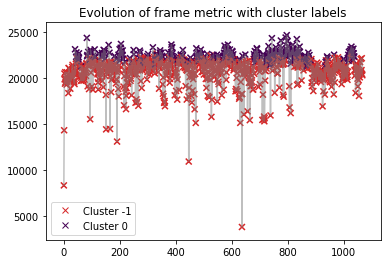

In [9]:
# Display metric evolution with clustering identity
cmap = matplotlib.cm.get_cmap("viridis")
cmap.set_under("C3")

plt.figure()
plt.title("Evolution of frame metric with cluster labels")
plt.plot(metric, color="gray", alpha=0.5)
plt.scatter(np.arange(len(wrp_stack)), metric, marker="x",
            c=labels, cmap=cmap, vmin=0, vmax=labels.max() + 1)
if len(np.unique(labels)) < 10:
    p = []
    for l in np.unique(labels):
        p.append(matplotlib.lines.Line2D([], [], linewidth=0, marker="x", 
                                         color=cmap(l / (labels.max() + 1)), label="Cluster %d" % l))
    plt.legend(handles=p)
plt.show()

## C. Fine tuning
Fine tune the network with those good frames and the projection's segmentation

In [10]:
model_name = "../data/models/190401_sep_synth_aug/"
out_model_name = "../data/models/test_axoid"

batch_size = 16

# Load model
input_channels = "RG" # Channels to use as input
u_depth = 4
out1_channels = 16
# model = CustomUNet(in_channels=len(input_channels), u_depth=u_depth, 
#                    out1_channels=out1_channels, device=device)
model = load_model(model_name, input_channels=input_channels, u_depth=u_depth, 
                   out1_channels=out1_channels, device=device)
metrics = {"dice": get_dice_metric()}
input_transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))
# Save future model
os.makedirs(out_model_name, exist_ok=True)
shutil.copy("../axoid/detection/deeplearning/model.py", os.path.join(out_model_name, "utils_model_save.py"))
model_ft = copy.deepcopy(model)

In [11]:
# Warp as annotation from automatic frame detection
annot_idx = np.where(labels == max_cluster)[0]
annot_proj = wrp_stack[annot_idx].mean(0)
if len(annot_idx) < 50:
        annot_proj = filters.gaussian(annot_proj, multichannel=True)
        annot_proj = np.stack([filters.median(to_npint(annot_proj[..., c])) for c in range(3)], axis=-1) / 255
seg_annot = segment_projection(annot_proj, min_area=11, separation_border=False)

n_train = min(int(0.6 * len(annot_idx)), 30)
n_valid = min(int(0.4 * len(annot_idx)), 20)
rgb_train = wrp_stack[annot_idx[:n_train]]
rgb_valid = wrp_stack[annot_idx[n_train: n_train + n_valid]]
seg_train = np.array([seg_annot] * len(rgb_train))
seg_valid = np.array([seg_annot] * len(rgb_valid))

print("%d frames for training, %d for validation" % (len(rgb_train), len(rgb_valid)))
@interact(n=(0, len(annot_idx) - 1))
def plot(n=0):
    plt.figure()
    plt.title("Frame %d" % annot_idx[n])
    plt.imshow(overlay_mask(wrp_stack[annot_idx[n]], seg_annot, 0.5, [1,1,1]))
    plt.show()

30 frames for training, 20 for validation


interactive(children=(IntSlider(value=0, description='n', max=295), Output()), _dom_classes=('widget-interact'…

In [11]:
learning_rate = 0.0005
contour, separation = False, True

seg_train = seg_train.astype(rgb_train.dtype)
seg_valid = seg_valid.astype(rgb_valid.dtype)
weights_train = compute_weights(seg_train, contour=contour, separation=separation)
weights_valid = compute_weights(seg_valid, contour=contour, separation=separation)

@interact(image=(0, len(weights_train) + len(weights_valid) - 1))
def plot_experiment(image=0):
    if image < len(weights_train):
        rgb = rgb_train
        seg = seg_train
        wgt = weights_train
    else:
        rgb = rgb_valid
        seg = seg_valid
        wgt = weights_valid
    image %= len(weights_train)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg[image], cmap="gray")
    plt.subplot(133)
    plt.title("Pixel weighting")
    plt.imshow(wgt[image], vmax=max(wgt[image].max(), 0.1))
    plt.colorbar(fraction=0.035, pad=0.02)
    plt.tight_layout()
    plt.show()

start = time.time()
model_ft = fine_tune(model_ft, rgb_train, seg_train, weights_train, rgb_valid, seg_valid,
                     data_aug=True, n_iter_min=0, n_iter_max=1000, patience=200,
                     batch_size=batch_size, learning_rate=learning_rate, verbose=1)
print("\nFine tuning took %.1f s." % (time.time() - start))

interactive(children=(IntSlider(value=0, description='image', max=29), Output()), _dom_classes=('widget-intera…

Initial val_dice = 0.688063
Iteration (min: 0 - max 1000): 
50: dice = 0.815934 - val_dice = 0.805373
100: dice = 0.858096 - val_dice = 0.845055
150: dice = 0.880382 - val_dice = 0.857787
200: dice = 0.889899 - val_dice = 0.870486
250: dice = 0.902467 - val_dice = 0.877490
300: dice = 0.915948 - val_dice = 0.886559
350: dice = 0.928779 - val_dice = 0.896314
400: dice = 0.931101 - val_dice = 0.891013
450: dice = 0.927735 - val_dice = 0.893472
500: dice = 0.929187 - val_dice = 0.890183
550: dice = 0.927174 - val_dice = 0.889079
600: dice = 0.943779 - val_dice = 0.904350
650: dice = 0.939602 - val_dice = 0.897506
700: dice = 0.936834 - val_dice = 0.899308
750: dice = 0.929032 - val_dice = 0.896224
800: dice = 0.937185 - val_dice = 0.900415
850: dice = 0.950650 - val_dice = 0.905934
900: dice = 0.949229 - val_dice = 0.905392
200 iterations without validation improvements. Fine tuning is interrupted at iteration 923.
Best model fine tuned in iteration 723.
Best dice = 0.9208484888076782

Fi

## D. Prediction
Predict over the experiments

Predicted experiment (x2) in 5.1 s.


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

Computation of #ROIs took 0.1 s.
First occurences (except first frame): argmax = 425 - argmin = 2
47 frames with less than 3 ROIs
Warped first occurences (except first frame): argmax = 690 - argmin = 1
384 frames with less than 5 ROIs


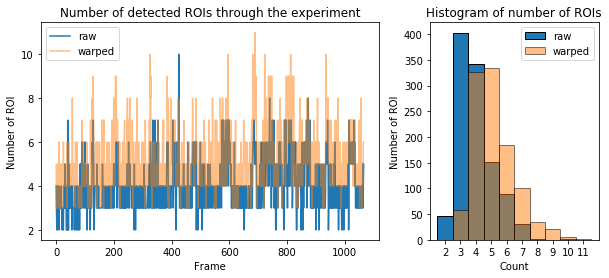

In [12]:
min_area = 11

# Predict and display results
start = time.time()
predictions = predict_stack(model_ft, rgb_stack, batch_size, input_channels=input_channels,
                            transform=input_transform)
predictions = torch.sigmoid(predictions)
detections = (predictions > 0.5).numpy().astype(np.bool)
for i in range(len(detections)):
    detections[i] = morphology.remove_small_objects(detections[i], min_area)

predictions_wrp = predict_stack(model_ft, wrp_stack, batch_size, input_channels=input_channels,
                                transform=input_transform)
predictions_wrp = torch.sigmoid(predictions_wrp)
detections_wrp = (predictions_wrp > 0.5).numpy().astype(np.bool)
for i in range(len(detections_wrp)):
    detections_wrp[i] = morphology.remove_small_objects(detections_wrp[i], min_area)
print("Predicted experiment (x2) in %.1f s." % (time.time() - start))
    
if seg_stack is not None:
    print("Dice =", dice_coef(detections, seg_stack))
    print("Warped dice =", dice_coef(detections_wrp, seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(232)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    plt.subplot(233)
    if seg_stack is not None:
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets(detections[image], seg_stack[image]))
    else:
        plt.title("Binary prediction")
        plt.imshow(detections[image], cmap="gray")
    plt.subplot(234)
    plt.title("Warped input")
    plt.imshow(wrp_stack[image])
    plt.subplot(235)
    plt.title("Prediction")
    plt.imshow(predictions_wrp[image], cmap="gray")
    plt.subplot(236)
    if seg_stack is not None:
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets(detections_wrp[image], seg_stack[image]))
    else:
        plt.title("Binary prediction")
        plt.imshow(detections_wrp[image], cmap="gray")
    plt.tight_layout()
    plt.show()

start = time.time()
n_roi = np.zeros(len(rgb_stack), np.uint8)
for i in range(len(detections)):
    _, n = measure.label(detections[i], connectivity=1, return_num=True)
    n_roi[i] = n
print("Computation of #ROIs took %.1f s." % (time.time() - start))
print("First occurences (except first frame): argmax = %d - argmin = %d" % \
      (np.argmax(n_roi[1:]) + 1, np.argmin(n_roi[1:]) + 1))
print("%d frames with less than %d ROIs" % (np.sum(n_roi < stats.mode(n_roi)[0]), stats.mode(n_roi)[0]))
n_roi_wrp = np.zeros(len(wrp_stack), np.uint8)
for i in range(len(detections_wrp)):
    _, n = measure.label(detections_wrp[i], connectivity=1, return_num=True)
    n_roi_wrp[i] = n
print("Warped first occurences (except first frame): argmax = %d - argmin = %d" % \
      (np.argmax(n_roi_wrp[1:]) + 1, np.argmin(n_roi_wrp[1:]) + 1))
print("%d frames with less than %d ROIs" % (np.sum(n_roi_wrp < stats.mode(n_roi_wrp)[0]), 
                                            stats.mode(n_roi_wrp)[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [2, 1]})
ax1.set_title("Number of detected ROIs through the experiment")
ax1.plot(n_roi)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Number of ROI")
ax2.set_title("Histogram of number of ROIs")
ax2.hist(n_roi, bins=np.arange(n_roi.min(), n_roi.max() + 2), align='left', edgecolor='k')
ax2.set_xticks(np.arange(n_roi.min(), n_roi.max() + 1))
ax2.set_xlabel("Count")
ax2.set_ylabel("Number of ROI")
if wrp_stack is not None:
    ax1.plot(n_roi_wrp, alpha=0.5)
    ax2.hist(n_roi_wrp, bins=np.arange(n_roi_wrp.min(), n_roi_wrp.max() + 2), 
             align='left', edgecolor='k', alpha=0.5)
    ax2.set_xticks(np.arange(min(n_roi.min(), n_roi_wrp.min()), 
                             max(n_roi.max(), n_roi_wrp.max()) + 1))
    ax1.legend(["raw", "warped"])
    ax2.legend(["raw", "warped"])
plt.show()

In [13]:
# Test if prediction does not completely overfit projection
import imgaug.augmenters as iaa

tmp0 = iaa.Affine(rotate=(-10, 10),
                  scale=(0.8, 1.2),
                  translate_percent=(-0.2, 0.2),
                  shear=(-16, 16),
                  order=0).augment_images(wrp_stack)

tmp = predict_stack(model_ft, tmp0, batch_size, input_channels=input_channels,
                                transform=input_transform)
tmp = torch.sigmoid(tmp)
tmp = (tmp > 0.5).numpy().astype(np.bool)
for i in range(len(tmp)):
    tmp[i] = morphology.remove_small_objects(tmp[i], min_area)

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(tmp0[image])
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(tmp[image], cmap="gray")
    plt.subplot(133)
    plt.title("Overlay")
    plt.imshow(overlay_mask(tmp0[image], tmp[image], 0.5, [1,1,1]), cmap="gray")
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

In [14]:
# Save results for tracking tests
io.imsave("/home/user/talabot/workdir/RGB.tif", to_npint(wrp_stack))
io.imsave("/home/user/talabot/workdir/seg_ROI.tif", to_npint(detections_wrp))
io.imsave("/home/user/talabot/workdir/clust_rgb.png", to_npint(annot_proj))
io.imsave("/home/user/talabot/workdir/clust_seg.png", to_npint(seg_annot))

/home/user/anaconda3/envs/talabot/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: /home/user/talabot/workdir/clust_seg.png is a low contrast image
  warn('%s is a low contrast image' % fname)


# 2. Tracking

## A. Find initialization frame
Find automatically a good frame, or use projection's segmentation.

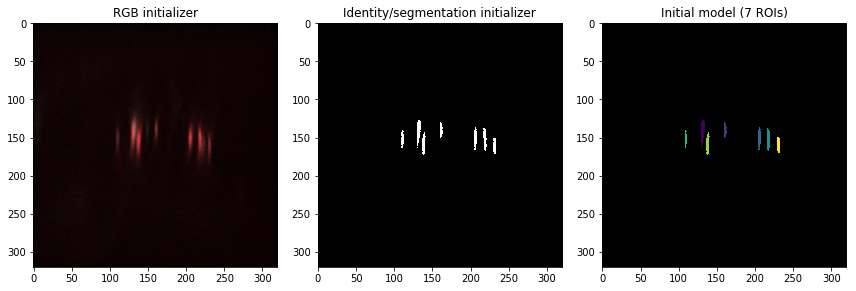

In [21]:
init_proj = True # True to use projection as initialization, False to find a frame automatically

id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])

# Initialization
model = InternalModel()
identities = np.zeros(detections_wrp.shape, np.uint8)
if init_proj:
#     rgb_init = projection
#     seg_init = seg_projection
    rgb_init = annot_proj
    seg_init = seg_annot
else: # automatic init frame
    # Take a frame with #ROIs == mode(#ROIs)
    mode_n_roi = stats.mode(n_roi_wrp)[0]
    
    # And that has the highest correlation score to the average of the frames with mode(#ROIs) ROIs
    mean_frame = wrp_stack[n_roi_wrp == mode_n_roi].mean(0)
    cross_corr = np.sum(wrp_stack[n_roi_wrp == mode_n_roi] * mean_frame, axis=(1,2,3))
    
    init_idx = np.argmax(cross_corr)
    # Transform that into full length index
    init_idx = np.argmax(np.cumsum(n_roi_wrp == mode_n_roi) == init_idx + 1)
    
    print("Frame %d taken as initial frame (%d ROIs)" % (init_idx, n_roi_wrp[init_idx]))
    rgb_init = wrp_stack[init_idx]
    seg_init = detections_wrp[init_idx]
    del mean_frame, cross_corr
    
model.initialize(rgb_init, measure.label(seg_init, connectivity=1))

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("RGB initializer")
plt.imshow(rgb_init)
plt.subplot(132)
plt.title("Identity/segmentation initializer")
plt.imshow(seg_init, cmap="gray")
plt.subplot(133)
plt.title("Initial model (%d ROIs)" % len(model.axons))
plt.imshow(model.image, cmap=id_cmap, vmin=0.99)
plt.tight_layout()
plt.show()

## B. Apply tracker

Updating model took 16 s.
Identity matching took 13 s.


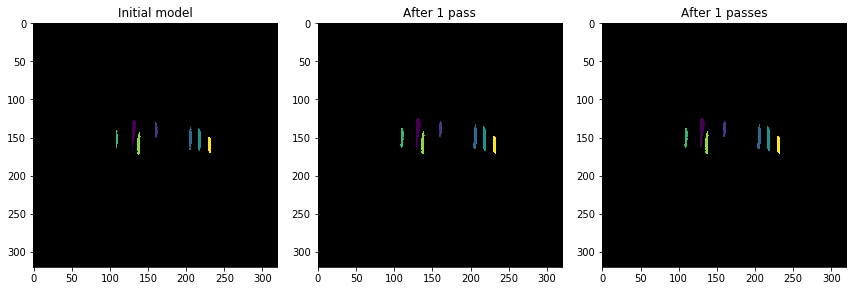

interactive(children=(IntSlider(value=0, description='image', max=567), Output()), _dom_classes=('widget-inter…

In [22]:
n_updates = 1

start = time.time()
model.initialize(rgb_init, measure.label(seg_init, connectivity=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("Initial model")
plt.imshow(model.image, cmap=id_cmap, vmin=0.99)

# Iterate n_updates times through the frames to udpate the model
for n in range(n_updates):
    for i in range(len(detections_wrp)):
        identities[i] = model.match_frame(wrp_stack[i], detections_wrp[i], time_idx=i)
        model.update(wrp_stack[i], identities[i], time_idx=i)
    if n == 0:
        plt.subplot(132)
        plt.title("After 1 pass")
        plt.imshow(model.image, cmap=id_cmap, vmin=0.99)
print("Updating model took %d s." % (time.time() - start))

start = time.time()
# Iterate a final time to finalize the identities (without updating the model)
for i in range(len(detections_wrp)):
    identities[i] = model.match_frame(wrp_stack[i], detections_wrp[i], time_idx=i)
print("Identity matching took %d s." % (time.time() - start))
plt.subplot(133)
plt.title("After %d passes" % n_updates)
plt.imshow(model.image, cmap=id_cmap, vmin=0.99)
plt.tight_layout()
plt.show()

if model.overlapping_axons:
    print("Some axons are overlapping on the model's image!")

# Display resulting identities
@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(wrp_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(detections_wrp[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=0.99, vmax=max([axon.id for axon in model.axons]))
    plt.tight_layout()
    plt.show()

**Error detection**  
Detect tracking errors through some metrics/infos/etc.

Argmax: 0 - argmin: 549
3 frames with less than 7 ROIs


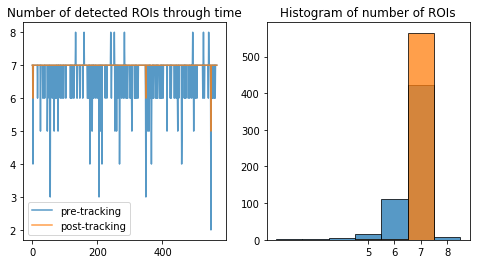

In [23]:
# Plot number of detected ROIs along time
n_roi_id = np.zeros(len(identities))
for i in range(len(n_roi)):
    n_roi_id[i] = measure.label(identities[i].astype(detections.dtype), connectivity=1, return_num=True)[1]
#     if n_roi_id[i] < 4:
#         print(i)
print("Argmax:", np.argmax(n_roi_id), "- argmin:", np.argmin(n_roi_id))
print("%d frames with less than %d ROIs" % (np.sum(n_roi_id < len(model.axons)), len(model.axons)))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(n_roi, alpha=0.75)
plt.plot(n_roi_id, alpha=0.75)
plt.legend(["pre-tracking", "post-tracking"])
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(n_roi, bins=np.arange(n_roi.min(), n_roi.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.hist(n_roi_id, bins=np.arange(n_roi_id.min(), n_roi_id.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.xticks(np.arange(n_roi_id.min(), n_roi.max() + 1))
plt.show()

In [24]:
# Look for frames where the row order of axons is violated
# Model row orders <=> rules
rules = get_rules(model.image)
print("Model rules:", rules, sep="\n")

verifs = rules_violated(rules, identities)
print("%d frames against the rules:\n" % np.sum(verifs),
      [i for i in range(len(identities)) if verifs[i]], sep="")

Model rules:
[[1 2]
 [1 3]
 [1 4]
 [1 6]
 [1 7]
 [2 3]
 [2 4]
 [2 7]
 [3 4]
 [3 7]
 [4 7]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 6]
 [5 7]
 [6 2]
 [6 3]
 [6 4]
 [6 7]]
0 frames against the rules:
[]


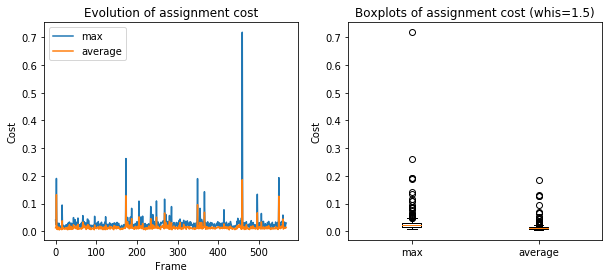

IQR 1.5: 30
[  2  16  44  67  96 123 173 177 184 187 205 210 214 234 239 248 268 271
 280 285 349 355 366 414 457 459 496 506 549 559]


In [25]:
# Compute cost of identities for each frame and look for outliers
# Compute first model's features
ids_to_idx = dict()
for i, axon in enumerate(model.axons):
    ids_to_idx.update({axon.id: i})

x_model = np.stack([axon.position for axon in model.axons], axis=0)
x_model -= x_model.mean(0)
area_model = np.array([axon.area for axon in model.axons])
area_model = area_model / area_model.mean()

# Loop over frames
cost_mean = np.zeros(len(identities))
cost_max = np.zeros(len(identities))
for i in range(len(identities)):
    regions = measure.regionprops(identities[i])
    # No ROI --> only dummy axons
    if len(regions) == 0:
        cost_mean[i] = model.TH_DUMMY
        cost_max[i] = model.TH_DUMMY
        continue
    
    # Compute frame features
    x_frame = np.array([region.centroid for region in regions])
    x_frame -= x_frame.mean(0)
    area_frame = np.array([region.area for region in regions])
    area_frame = area_frame / area_frame.mean()
    
    cost_matrix = model.W_AREA * np.abs(area_frame[:, np.newaxis] - area_model[np.newaxis, :])
    if len(regions) > 1 and len(model.axons) > 1:
        cost_matrix += model.match_inner_cost(x_frame, x_model, area_frame, area_model, identities.shape[1])
    
    cost = cost_matrix[np.arange(len(regions)), np.array([ids_to_idx[reg.label] for reg in regions])]
    if cost.size == 0:
        cost_mean[i] = np.nan
        cost_max[i] = np.nan
    else:
        cost_mean[i] = np.mean(cost)
        cost_max[i] = np.max(cost)

iqr_cutoff = 1.5
cost_max_nanfree = cost_max[np.logical_not(np.isnan(cost_max))]
cost_mean_nanfree = cost_mean[np.logical_not(np.isnan(cost_mean))]
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plt.title("Evolution of assignment cost")
plt.plot(cost_max)
plt.plot(cost_mean)
plt.legend(["max", "average"])
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.subplot(122, sharey=ax1)
plt.title("Boxplots of assignment cost (whis={})".format(iqr_cutoff))
plt.boxplot([cost_max_nanfree, cost_mean_nanfree], whis=iqr_cutoff, labels=["max", "average"])
plt.ylabel("Cost")
plt.show()
q25, q75 = np.percentile(cost_max_nanfree, 25), np.percentile(cost_max_nanfree, 75)
iqr = q75 - q25
outliers = np.where(cost_max_nanfree > (q75 + iqr * iqr_cutoff))[0]
print("IQR {}: {}".format(iqr_cutoff, outliers.size), outliers, sep="\n")

# 3. User correction (optional)

In [ ]:
indices = []
print(indices)

old_ids = identities[indices].copy()
choice_pattern = re.compile("[0-9]+,[0-9]+")

# Plot frames and allow re-labeling
for idx in indices:
    new_id = identities[idx].copy()
    labels, num_roi = measure.label(detections[idx], connectivity=1, return_num=True)
    regions = measure.regionprops(labels)
    
    next = False
    while not next:
        clear_output()
        plt.figure(figsize=(10,10))
        plt.suptitle("Frame %d" % idx)
        plt.subplot(221)
        plt.title("Model")
        plt.imshow(model.image, cmap=id_cmap, vmin=1, vmax=len(model.axons))
        plt.subplot(222)
        plt.title("Raw input")
        plt.imshow(rgb_stack[idx])
        plt.subplot(223)
        plt.title("Regions of detection")
        plt.imshow(labels, cmap=id_cmap, vmin=1)
        plt.subplot(224)
        plt.title("Current IDs")
        plt.imshow(new_id, cmap=id_cmap, vmin=1, vmax=len(model.axons))
        plt.tight_layout()
        plt.show()
        
        choice = input("Choose region and id as 'r,id' ('n' for next): ")
        if choice == "n":
            next = True
            time.sleep(1)
            continue
        elif not choice_pattern.match(choice):
            print("Incorrect input, retry")
            time.sleep(1)
            continue
        reg, id = map(int, choice.split(","))
        
        if reg not in np.arange(num_roi) + 1:
            print("Wrong region %d" % reg)
            time.sleep(1)
            continue
        elif id not in [axon.id for axon in model.axons]:
            if id == 0: # delete current assignment
                new_id[labels == reg] = 0
            else:
                print("Wrong ID %d" % id)
            time.sleep(1)
            continue
        else:
            new_id[new_id == id] = 0
            new_id[labels == reg] = id
        
    identities[idx] = new_id.copy()
clear_output()

@interact(idx=(0, len(indices) - 1))
def plot_corrections(idx=0):
    _, n_old = measure.label(old_ids[idx], connectivity=1, return_num=True)
    _, n_corr = measure.label(identities[idx], connectivity=1, return_num=True)
    
    plt.figure(figsize=(10,10))
    plt.suptitle("Frame %d" % indices[idx])
    plt.subplot(221)
    plt.title("Model")
    plt.imshow(model.image, cmap=id_cmap, vmin=1, vmax=len(model.axons))
    plt.subplot(222)
    plt.title("Raw input")
    plt.imshow(rgb_stack[indices[idx]])
    plt.subplot(223)
    plt.title("Old ID")
    plt.imshow(old_ids[idx], cmap=id_cmap, vmin=1, vmax=len(model.axons))
    plt.subplot(224)
    plt.title("New ID")
    plt.imshow(identities[indices[idx]], cmap=id_cmap, vmin=1, vmax=len(model.axons))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Extract fluorescence traces
Use the identities to extract the fluorescence traces of the axons through time.

Computing traces took 17.885 s.


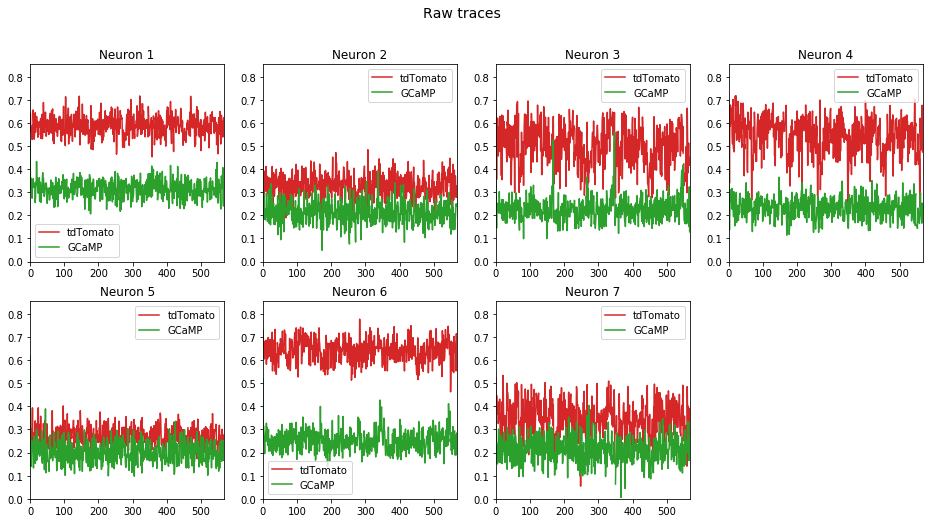

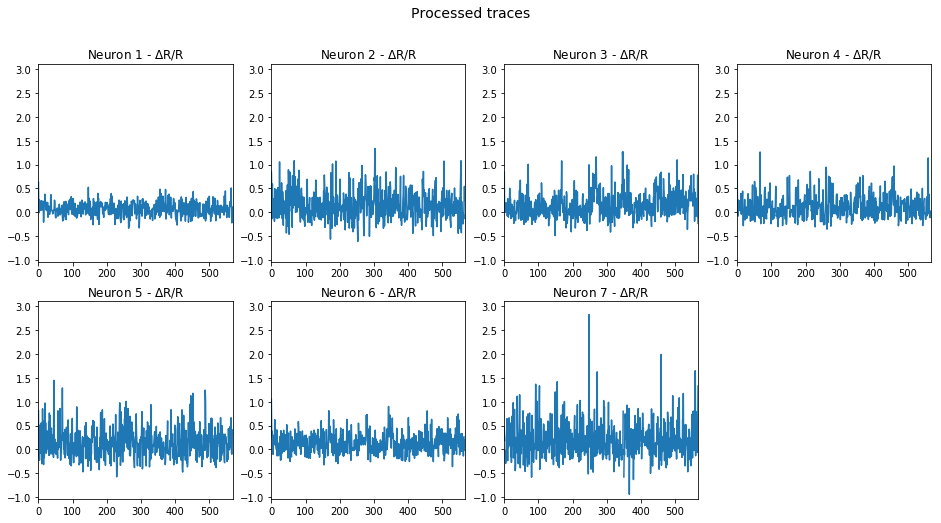

In [26]:
n_frames_0 = 24 # number of frames for the R_0 and F_0 computation

# If too many identities, do not compute traces (modify here to force computation)
if identities.max() >= 15:
    print(identities.max(), "different neurons identified, traces are not computed.\n")
    sys.exit()

# Mean noise intensity in background
bkg_r = np.mean(wrp_stack[np.logical_not(seg_stack),0])
# bkg_g = np.mean(rgb_stack[np.logical_not(seg_stack),1])
    
traces = np.ones((identities.max(), len(identities), 2)) * np.nan
dR_R = np.zeros((identities.max(), len(identities)))
has_tdTom = np.array([True] * identities.max())

start = time.time()
for i in range(len(identities)):
    for j in range(identities.max()):
        # Select ROI (optional dilation)
        roi = wrp_stack[i,...][(identities[i] == (j + 1))]
        if roi.size > 0:
            # Mean over non-zero values
            for k in range(2):
                traces[j , i, k] = np.mean(roi[roi[:,k] > 0, k])
#             traces[j, i, :] = roi.mean(0)[:2]
print("Computing traces took %.3f s." % (time.time() - start))

for i in range(identities.max()):
    # Check if tdTomato is present in the neuron by comparing the mean trace to bkg noise
    if np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]) >= 1.1 * bkg_r:
        R_t = traces[i,...,1] / traces[i,...,0]
    else: # no tdTomato, compute F instead of R
        R_t = traces[i,...,1]
        has_tdTom[i] = False
        print("Neuron {} has no tdTomato (mean < 1.1 * bkg: {:.3f} < {:.3f}). "
              "Fluorescence computed as dF/F.".format(
            i + 1, np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]), 1.1 * bkg_r))
    R_0 = np.convolve(R_t, np.ones(n_frames_0) / n_frames_0, 'valid')
    R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    # If no window of n_frames_0 exists, search for smaller ones
    for j in range(1, n_frames_0):
        if not np.isinf(R_0):
            break
        R_0 = np.convolve(R_t, np.ones(n_frames_0 - j) / (n_frames_0 - j), 'valid')
        R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    dR_R[i] = (R_t - R_0) / R_0

N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(dR_R[has_tdTom]) + np.isinf(dR_R[has_tdTom]), 0, dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(dR_R[np.logical_not(has_tdTom)]) + np.isinf(dR_R[np.logical_not(has_tdTom)]),
                            0, dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, ymax_R if has_tdTom[i] else ymax_F)
plt.show()

/home/user/anaconda3/envs/talabot/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


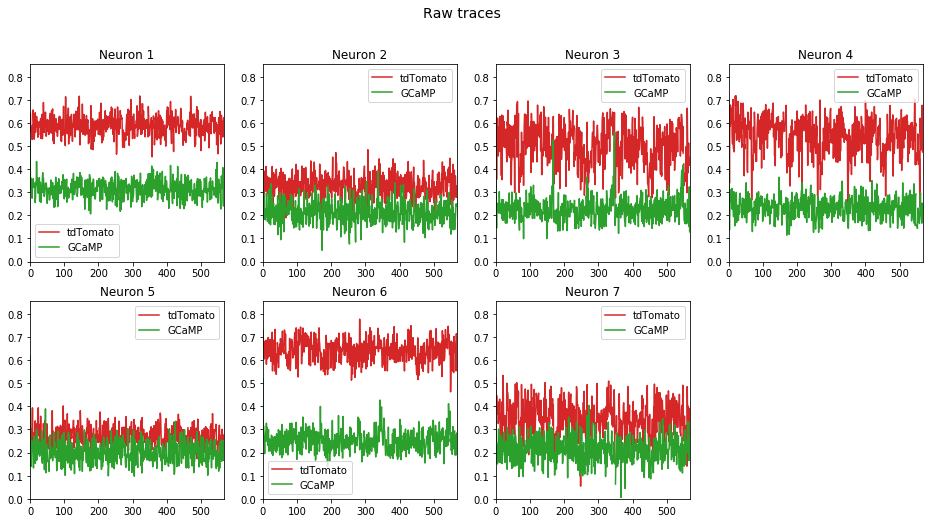

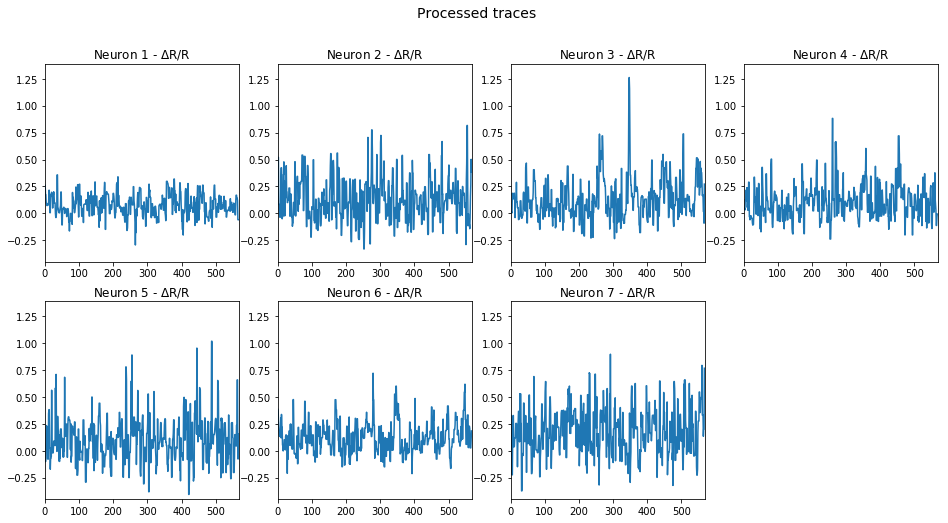

In [27]:
k = 3
new_dR_R = dR_R.copy()
for i in range(new_dR_R.shape[0]):
    for j in range(new_dR_R.shape[1]):
        new_dR_R[i, j] = np.nanmedian(dR_R[i, j - k//2:j + k//2 + 1])

N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(new_dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(new_dR_R[has_tdTom]) + np.isinf(new_dR_R[has_tdTom]), 0, 
                            new_dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(new_dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(new_dR_R[np.logical_not(has_tdTom)]) + np.isinf(new_dR_R[np.logical_not(has_tdTom)]),
                            0, new_dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(new_dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, 
             ymax_R if has_tdTom[i] else ymax_F)
plt.show()

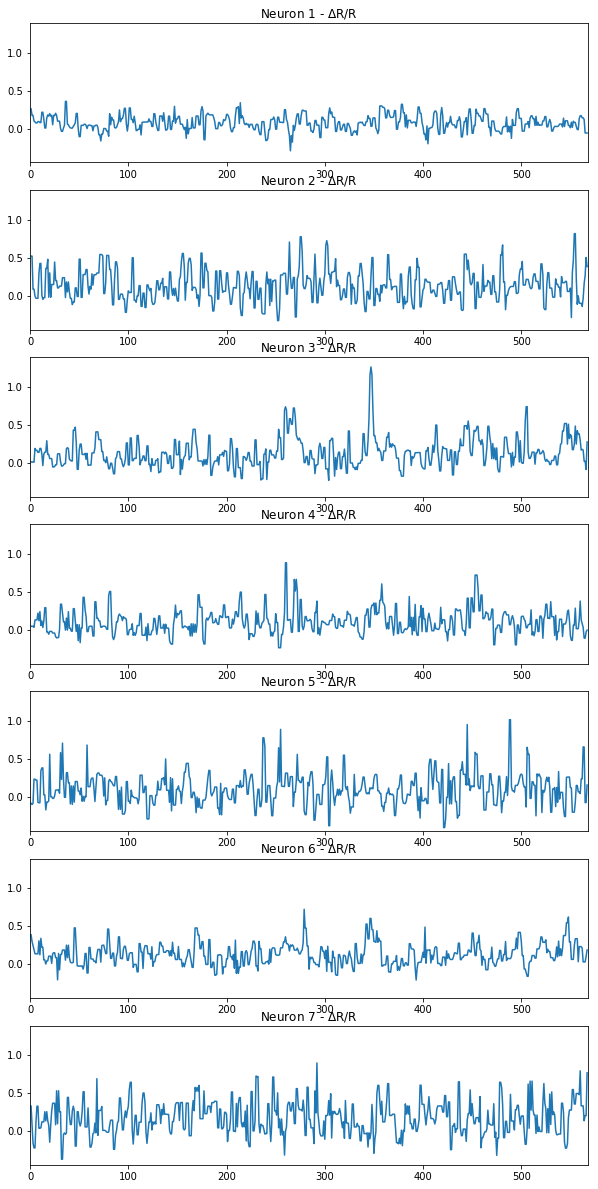

In [28]:
plt.figure(figsize=(10, 3 * identities.max()))
for i in range(identities.max()):
    plt.subplot(identities.max(), 1, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(new_dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, 
             ymax_R if has_tdTom[i] else ymax_F)
plt.show()